# German Credit Analysis

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

## Read and Process Data

In [7]:
df_ = pd.read_csv('data/german_credit/german_credit_data.csv')
df = df_.copy()

target_name = 'Risk'
target = df[target_name].replace({'good': 0, 'bad': 1})

df['Risk'] = target


In [8]:
# Initialize a label encoder
label_encoder = LabelEncoder()
label_mappings = {}


# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if column is not target_name and df[column].dtype == 'object':
        # Handle missing values by filling with a placeholder and then encoding
        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


# For columns with NaN values that are numerical, we will impute them with the median of the column
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

# Display the first few rows of the transformed dataframe
df.head()


Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount   
0   67    1    2        1                0                 1           1169  \
1   22    0    2        1                1                 2           5951   
2   49    1    1        1                1                 0           2096   
3   45    1    2        0                1                 1           7882   
4   53    1    2        0                1                 1           4870   

   Duration  Purpose  Risk  
0         6        5     0  
1        48        5     1  
2        12        3     0  
3        42        4     0  
4        24        1     1

## Model Training

In [9]:
features = [
    'Age', 
    'Sex', 
    'Job', 
    'Housing', 
    'Saving accounts', 
    'Checking account',
    'Credit amount', 
    'Duration', 
    'Purpose', 
]

df_X = df[features].copy()
df_y = target

In [10]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
model = BlackBoxModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.7400000095367432

## Counterfactual Explanation

In [11]:
sample_num = 50
delta = 0.1
alpha = 0.05
N=10
explain_columns = [
    'Age', 
    'Sex', 
    'Job', 
    'Housing', 
    'Saving accounts', 
    'Checking account',
    'Credit amount', 
    'Duration', 
    'Purpose', 
]

indice = (X_test.sample(sample_num)).index

df_explain = X_test.loc[indice]

# X = X_test.loc[indice].values
y = model(torch.FloatTensor(df_explain.values))

y_target = torch.distributions.beta.Beta(0.1, 0.9).sample((sample_num,))

y_true = y_test.loc[indice]

In [12]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    df_X=df_explain, 
    explain_columns=explain_columns,
    y_target=y_target, 
    lr=1e-1, 
    n_proj=N,
    delta=delta)

DEBUG:root:test


In [13]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

0.29509245126946043

In [14]:
explainer.wd.distance_interval(y, y_target, delta=delta, alpha=0.10)

(0.0, 0.3910184881084546)

In [15]:
explainer.optimize(U_1=0.5, U_2=0.3, l=0.2, r=1, max_iter=50, tau=1e3)

INFO:root:Optimization started
INFO:root:U_1-Qu_upper=0.5, U_2-Qv_upper=-0.09311867644783989
INFO:root:eta=1, l=0.24000000000000002, r=1
INFO:root:Iter 1: Q = 0.020130539312958717, term1 = 0.11269549280405045, term2 = 0.020130539312958717
INFO:root:U_1-Qu_upper=0.3585263810525213, U_2-Qv_upper=0.1231054071918446
INFO:root:eta=0.8057434917100359, l=0.278, r=1
INFO:root:Iter 2: Q = 0.005472788121551275, term1 = 0.019613903015851974, term2 = 0.0020635100081562996
INFO:root:U_1-Qu_upper=0.44378397533107145, U_2-Qv_upper=0.2484302487017419
INFO:root:eta=0.7408798702261932, l=0.31410000000000005, r=1
INFO:root:Iter 3: Q = 0.002561278874054551, term1 = 0.002229396253824234, term2 = 0.0026773535646498203
INFO:root:U_1-Qu_upper=0.5, U_2-Qv_upper=0.23826582819219883
INFO:root:eta=0.7786345712936303, l=0.34839500000000007, r=1
INFO:root:Iter 4: Q = 0.0023060739040374756, term1 = 0.003761661471799016, term2 = 0.0018922509625554085
INFO:root:U_1-Qu_upper=0.4885139509015454, U_2-Qv_upper=0.268980869

In [ ]:
# if no feasible solution is found but we still want to check the result:
# explainer.best_X = explainer.X 

In [26]:
X_s = explainer.best_X[:, explainer.explain_indices].clone()
X_t = explainer.X_prime.clone()

In [27]:
np.sqrt(explainer.swd.distance(X_s, X_t, delta)[0].item())

0.07991335944659775

In [ ]:
explainer.swd.distance_interval(X_s, X_t, delta=delta, alpha=alpha)

In [29]:
factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)

dtype_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X.columns:
        if v[:3] == 'int':
            counterfactual_X[k] = counterfactual_X[k].round().astype(v)
        else:
            counterfactual_X[k] = counterfactual_X[k].astype(v)

factual_y = pd.DataFrame(y.detach().numpy(),columns=[target_name], index=factual_X.index)
counterfactual_y = pd.DataFrame(explainer.y.detach().numpy(),columns=[target_name], index=factual_X.index)

In [35]:
# Now, reverse the label encoding using the label_mappings
for dft in [factual_X, counterfactual_X]:
    for column, mapping in label_mappings.items():
        if column in dft.columns:
            # Invert the label mapping dictionary
            inv_mapping = {v: k for k, v in mapping.items()}
            # Map the encoded labels back to the original strings
            dft[column] = dft[column].map(inv_mapping)

In [39]:
factual = factual_X
counterfactual = counterfactual_X

factual[target_name] = factual_y
counterfactual[target_name] = counterfactual_y

In [40]:
factual_X.head(5)

Age   Sex  Job Housing Saving accounts Checking account  Credit amount   
436   23  male    1    rent      quite rich          Unknown            660  \
899   42  male    2     own          little           little           4153   
346   23  male    2     own          little         moderate            882   
60    27  male    2     own          little         moderate           1391   
867   42  male    2     own          little          Unknown           3331   

     Duration              Purpose      Risk  
436         6              repairs  0.004947  
899        18  furniture/equipment  0.837388  
346        13             radio/TV  0.638600  
60          9             business  0.210005  
867        12  furniture/equipment  0.040180

In [41]:
counterfactual_X.head(5)

Age   Sex  Job Housing Saving accounts Checking account  Credit amount   
436   23  male    1    rent      quite rich          Unknown            865  \
899   40  male    2     own          little          Unknown           3528   
346   27  male    1     own          little         moderate           2690   
60    27  male    2     own          little         moderate           1417   
867   41  male    2     own          little          Unknown           3423   

     Duration              Purpose      Risk  
436         6              repairs  0.005088  
899        15  furniture/equipment  0.022747  
346         8  furniture/equipment  0.000813  
60          9             business  0.157634  
867        12  furniture/equipment  0.212495

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

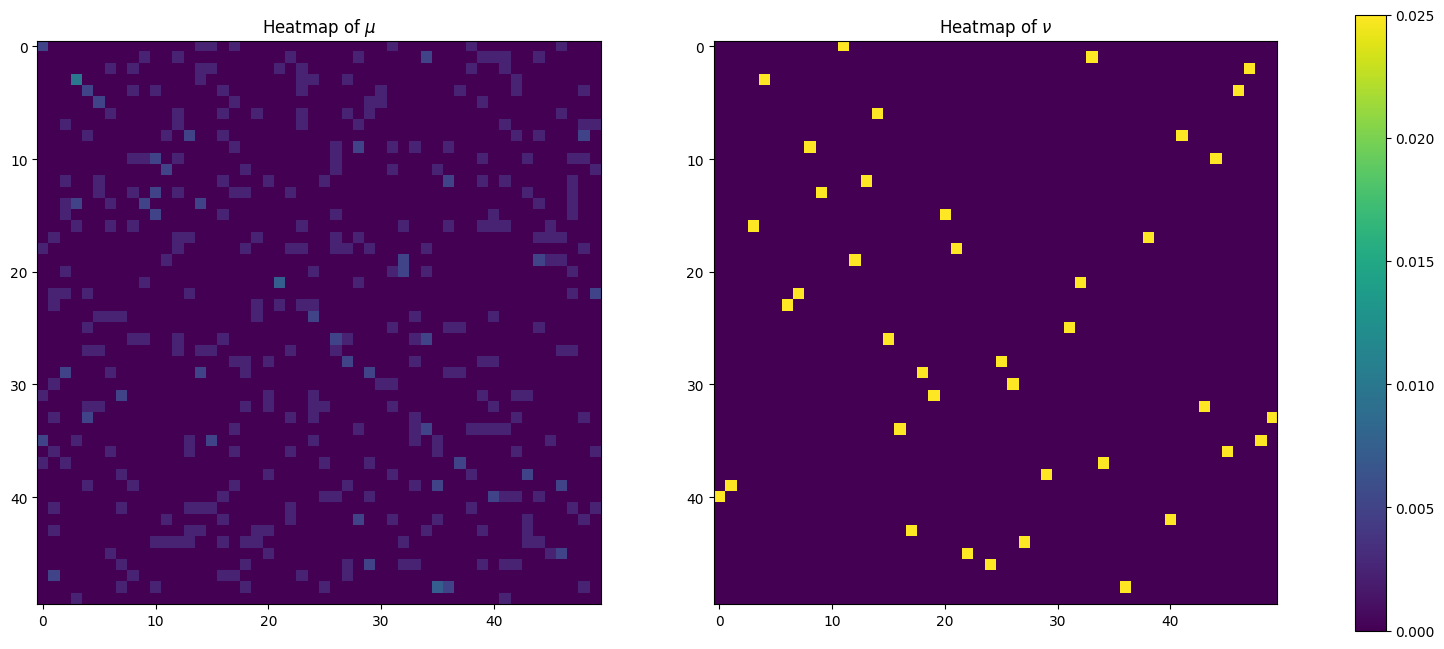

In [16]:
import matplotlib.pyplot as plt

matrix_nu = explainer.wd.nu.detach().numpy()

mu_avg = torch.zeros_like(explainer.swd.mu_list[0])
for mu in explainer.swd.mu_list:
    mu_avg += mu

total_sum = mu_avg.sum()

matrix_mu = mu_avg / total_sum

# Determine the global minimum and maximum values across both matrices
vmin = min(matrix_mu.min(), matrix_nu.min())
vmax = max(matrix_mu.max(), matrix_nu.max())

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# First subplot for matrix_mu
im_mu = axs[0].imshow(matrix_mu, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Heatmap of $\mu$")

# Second subplot for matrix_nu
im_nu = axs[1].imshow(matrix_nu, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Heatmap of $\\nu$")

# Create a colorbar for the whole figure
fig.colorbar(im_mu, ax=axs, orientation='vertical')

# Display the plots
plt.show()